# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# import once, run anywhere

import math     
from glob import glob
import random        
import os

import numpy as np
import cv2   

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import torch.optim as optim

from PIL import Image
from PIL import ImageFile

import matplotlib.pyplot as plt   
%matplotlib inline        

from tqdm import tqdm

use_cuda = torch.cuda.is_available()

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [3]:
# doing some more invistigations on imported lists
print(human_files.shape)
print(dog_files.shape)
print(human_files[0])
print(type(human_files[0]))

(13233,)
(8351,)
/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg
<class 'numpy.str_'>


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


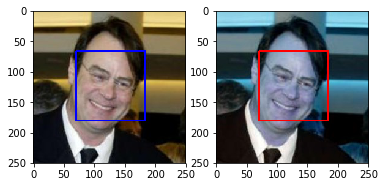

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.subplot(121)
plt.imshow(cv_rgb)
# to see the difference between the BGR and RGB
plt.subplot(122)
plt.imshow(img)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [6]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# initializing variables to track accuracy for humans and dogs indep.
human_acc, dog_acc = 0, 0

for i in tqdm(range(100)):
    # counting when human face is detected
    human_acc += int(face_detector(human_files_short[i]))
    # counting when no human face is detected
    dog_acc += int(not face_detector(dog_files_short[i]))


# overall accueracy
overall_acc = (human_acc + dog_acc) /2

# printing results
print(f'Accuracy detecting human faces: {human_acc}%\n\
Accuracy not detecting dog faces as human: {dog_acc}% (detected human faces {100-dog_acc}% of the time.)\n\
Overall accuracy: {overall_acc:.2f}%')

100%|██████████| 100/100 [00:30<00:00,  3.29it/s]

Accuracy detecting human faces: 98%
Accuracy not detecting dog faces as human: 83% (detected human faces 17% of the time.)
Overall accuracy: 90.50%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [5]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)# check if CUDA is available

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 105296632.11it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [8]:
# printing VGG16 archeticture.
# this just to help me better expect
# what to pass in  and the return size is.
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

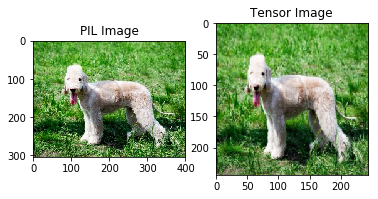

In [7]:
# choosing an image at random
index = np.random.randint(len(dog_files))
img = Image.open(dog_files[index])

# preprocessing
tensor_img = TF.to_tensor(TF.resize(img, [244, 244]))
# displying
plt.subplot(121)
plt.imshow(img)
plt.title('PIL Image')
plt.subplot(122)
plt.imshow(tensor_img.permute(1, 2, 0)) # permute to match the ndarray image dimension (chennel depth last)
plt.title('Tensor Image');

In [8]:
# calling Vgg16 on the processed image to make sure 
# the result is as expected (an index)

# the size of the image VGG16 expects
VGG16_in_size = torch.Size([1, 3, 244, 244])

tensor_img.resize_(VGG16_in_size)

if use_cuda:
    tensor_img = tensor_img.cuda()

prediction = VGG16(tensor_img)
print(prediction.shape)
prediction.topk(1)

torch.Size([1, 1000])


(tensor([[ 15.2353]], device='cuda:0'), tensor([[ 181]], device='cuda:0'))

In [9]:
VGG16_IN_SIZE = torch.Size([1, 3, 244, 244]) # declared with constant naming convention

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # load image
    img = Image.open(img_path)
    
    # turn into tensor, using gpu if available
    if use_cuda:
        tensor_img = TF.to_tensor(TF.resize(img, [244, 244])).cuda()
    else:
        tensor_img = TF.to_tensor(TF.resize(img, [244, 244]))
    
    # resize tensor
    tensor_img.resize_(VGG16_IN_SIZE)
    
    # prediction is the index of highest value
    VGG16.eval() # to make prediction faster, no grad calculations
    output = F.softmax(VGG16(tensor_img), 1)
    prediction = torch.topk(output, 1)[1].item()
    
    return prediction # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
DOG_CLASS_RANGE = (151, 268) # inclusive at both ends

def dog_detector(img_path):
    ## TODO: Complete the function.
    
    return DOG_CLASS_RANGE[0] <= VGG16_predict(img_path) <= DOG_CLASS_RANGE[1] # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# initializing variables to track accuracy for humans and dogs indep.
human_acc, dog_acc = 0, 0

for i in tqdm(range(100), position=0, leave=True):
    # counting when human face is detected
    human_acc += int(not dog_detector(human_files_short[i]))
    # counting when no human face is detected
    dog_acc += int(dog_detector(dog_files_short[i]))


# overall accueracy
overall_acc = (human_acc + dog_acc) /2

# printing results
print(f'Accuracy detecting dogs: {dog_acc}%\n\
Accuracy not detecting humans as dogs: {human_acc}% (detected humans {100-human_acc}% of the time)\n\
Overall accuracy: {overall_acc:.2f}%')

100%|██████████| 100/100 [00:12<00:00,  8.74it/s]

Accuracy detecting dogs: 99%
Accuracy not detecting humans as dogs: 100% (detected humans 0% of the time)
Overall accuracy: 99.50%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

Number of classes the network will be trained to detect is 133.

Total number of train images is 6680.
Total number of valid images is 835.
Total number of test images is 836.



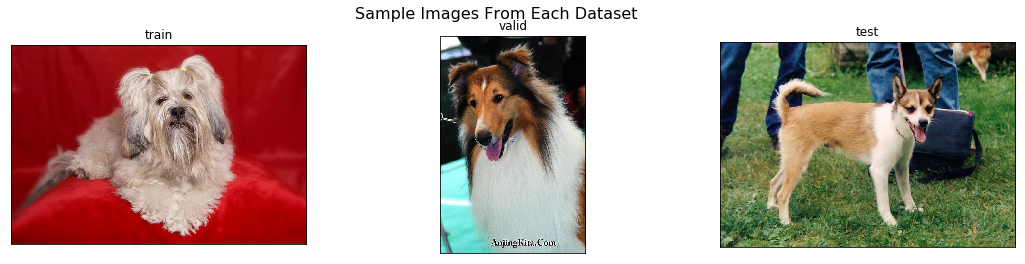

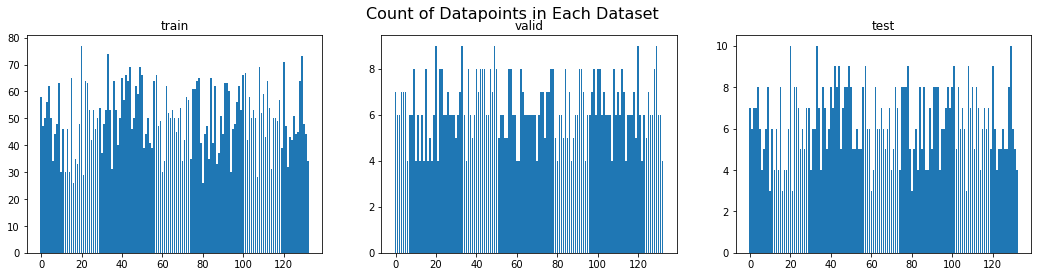

In [11]:
base_dir = '/data/dog_images/'
sub_dir = ['train', 'valid', 'test']

# initialize to get all necessary exploratory details
classes = os.listdir(base_dir+sub_dir[0]) # I made sure they are all the same
n_class_images = {k : {} for k in sub_dir}
images = {k : None for k in sub_dir}

# print stats
print(f'Number of classes the network will be trained to detect is {len(classes)}.\n')
for d in sub_dir:
    for cl in classes:
        n_class_images[d][cl] = len(os.listdir(base_dir+d+'/'+cl)) # in case needed later
    else:
        rand_class = random.choice(classes)
        rand_class_path = base_dir+d+'/'+rand_class
        img_names = os.listdir(rand_class_path)
        rand_img_name = random.choice(img_names)
        images[d] = Image.open(rand_class_path+'/'+rand_img_name)
    print(f'Total number of {d} images is {sum(n_class_images[d].values())}.')
print()
    
# showing sample images 
fig = plt.figure(figsize=(18, 4))
for i, d in enumerate(sub_dir):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    ax.imshow(images[d])
    ax.set_title(d)
fig.suptitle('Sample Images From Each Dataset', fontsize=16)
    
# showing class distributions
fig2 = plt.figure(figsize=(18, 4))
for i, d in enumerate(sub_dir):
    ax = fig2.add_subplot(1, 3, i+1)
    ax.bar(range(len(classes)), list(n_class_images[d].values()), align='center')
    ax.set_title(d)
fig2.suptitle('Count of Datapoints in Each Dataset', fontsize=16);

In [12]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
image_size = torch.Size((244, 244)) 
batch_size = 32

ImageFile.LOAD_TRUNCATED_IMAGES = True # to resolve error thrown while loading some images


prep_transform = transforms.Compose([transforms.Resize(image_size),
                                     transforms.CenterCrop(image_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),   # suggested in pytorch forums
                                                          (0.229, 0.224, 0.225))]) # to match training transforms
                                                                                   # of pretrained vgg16 network

augment_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(15),
                                        prep_transform])

train_data = datasets.ImageFolder(base_dir+'train', transform = augment_transform)
valid_data = datasets.ImageFolder(base_dir+'valid', transform = prep_transform)
test_data = datasets.ImageFolder(base_dir+'test', transform = prep_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True) 

# to be passed to train function
loaders_scratch = {'train' : train_loader,
                   'valid' : test_loader,
                   'test'  : test_loader}

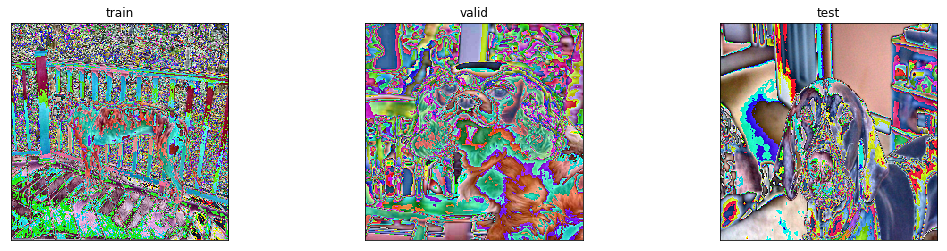

In [16]:
# Showing some of the loaded images to make sure it works as expected
verif_data = {'train' : next(iter(train_loader)),
              'valid' : next(iter(test_loader)),
              'test'  : next(iter(test_loader))}

fig = plt.figure(figsize = (18, 4))
for i, each in enumerate(verif_data):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    ax.imshow(TF.to_pil_image(verif_data[each][0][0])) 
    ax.set_title(each)

Applying the `transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))` to the images made them uncomprehensible for our human eyes, but it actually raised the accuracy of `model_transfer` for the same amout of trainning with the same hyperparameters, from 66% to 80%.

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

1. The size of input images for VGG16 (244x244) is used as the image size for this model as well. When images are viwed with this size they are reasonably clear and have enough details to potentially give good accuracy.<br>
The images were cropped to this size. As, by first viewing some of them, most of them have been found to 
contain a large background that does not contain any features of the desired objects to be classified (the dogs).

2. Yes, the data was augmented by horizontal flipping, and 15 degrees rotation, applied at random to the training dataset. This has been chosen to increase the variability in the images as the data set is not large enought to contain enough vaiability, so I tried to enhance the training process a little by augmenting the data.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [18]:
%%bash

# to make sure I reference the correct pytorch documentation
conda list | grep torch

libtorch                  0.1.12                  nomkl_0    defaults
pytorch                   0.4.0           py36_cuda8.0.61_cudnn7.1.2_1    pytorch
torchvision               0.2.1                    py36_1    pytorch


In [13]:
class gauss_Linear(nn.Linear):
    """An implementation of pytorch linear layers, that overrides parameters initialization function
     `reset_parameters` to use gaussian distribution instead of uniform ditribution."""
    
    def __inti__(self, in_features, out_features, bias=True):
        Linear.__init__(self, in_features, out_features, bias=True)
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.normal_(0, stdv)
        if self.bias is not None:
            self.bias.data.fill_(0)

In [70]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        
        # defining hyperparameters of conv. part and initial empty list
        self.input_image_size = image_size # the image size defined to load and preprossess images for the model 
        self.conv_depth = [3, 16, 40, 100, 256]
        self.conv_layers = nn.ModuleList([])
        
        # filling in the convulutional list
        for in_depth, out_depth in zip(self.conv_depth[:-1], self.conv_depth[1:]):
            self.conv_layers.extend([nn.Conv2d(in_depth, out_depth, 3),
                                nn.ReLU(),
                                nn.MaxPool2d(2, 2)])

        
        # defining hyper parameters of fully connected layers
        input_nodes = self.input_image_size[0]
        for layer in self.conv_layers:
            input_nodes = self.get_output_dim(layer, input_nodes)
        input_nodes *= input_nodes
        input_nodes *= self.conv_depth[-1]
        
        input_nodes = int(input_nodes)
        output_nodes = 133
        self.dense_nodes = [input_nodes, 1024, 512, output_nodes]
        
        # creating the fully connected classifier part
        self.dense_layers = nn.ModuleList([gauss_Linear(self.dense_nodes[0], self.dense_nodes[1])])
        
        for in_nodes, out_nodes in zip(self.dense_nodes[1:-1], self.dense_nodes[2:]):
            self.dense_layers.extend([nn.Dropout(0.3),
                                      nn.ReLU(),
                                 gauss_Linear(in_nodes, out_nodes)])
     
    def get_output_dim(self, layer, input_dim):
        """A general method to get output dimensions from parameters of layer and input dimensions.
        
           Arguments:
           -----
               layer (torch.nn.Module): the layer to find out dimensions of.
               input_dim (int): dimensions of the input layer.
           
           Return:
           -------
               output_dim (int)
       """
        # TODO (Suggested development): make input_dim accept torch.Size input for non-square images
        output_dim = input_dim
        
        if isinstance(layer, nn.MaxPool2d):
            output_dim = int((input_dim + 2*layer.padding - layer.dilation*(layer.kernel_size - 1) - 1)/layer.stride + 1)
            
        if isinstance(layer, nn.Conv2d):
            output_dim = int((input_dim + 2*layer.padding[0] - layer.dilation[0]*(layer.kernel_size[0] - 1) - 1)/layer.stride[0] + 1)
        
        return output_dim
        
        
    
    def forward(self, x):
        ## Define forward behavior
        
        for each in self.conv_layers:
            x = each(x)
        
        # flatten x
        x = x.view(x.shape[0], -1)
        
        for each in self.dense_layers:
            x = each(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [66]:
# printing the network
model_scratch

Net(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 30, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(30, 100, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(100, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): ModuleList(
    (0): gauss_Linear(in_features=43264, out_features=1024, bias=True)
    (1): Dropout(p=0.3)
    (2): ReLU()
    (3): gauss_Linear(in_features=1024, out_features=512, bias=True)
    (4): Dropout(p=0.3)
    (5): ReLU()
    (6): gauss_Linear(in_features=512, out_features=133, bias=True)
  )


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I have added a set of convolutional layers that gradually increase the depth of the input image. I have cascad them in pairs; two convolutional layers that take the image from depth to the next, to give the model more parameters to tweek along the way, to be able to better differentiate and classify images. Each of those pairs is mediated with a `ReLU` activation layer, and followed by a `maxpool` layer to reduce the dimensions of the image.

I have then added fully connected layers to classify the image according to features outputed from the convolutional layers. I have chosen to make them two layers, 512 nodes each. (a number less than the number of nodes of the features layer and the number of classes).

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [71]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.001, momentum = 0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [29]:
def save_model(path, model, messages, optimizer, criterion):
    full_dict = dict()
    try: # to save model parameters when trianing model_scratch and pass when training model_transfer
        full_dict['hyperparams'] = {'image_size': model.input_image_size,
                                    'conv_depth': model.conv_depth,
                                    'dense_nodes': model.dense_nodes,
                                    'optimizer': optimizer,
                                    'criterion': criterion}
    except:
        pass
    full_dict['train_messages'] = messages
    full_dict['state_dict'] = model.state_dict()
    torch.save(full_dict, path)

In [17]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    # to save with model, to compare different models
    train_messages = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in tqdm(enumerate(loaders['train']), 
                                              position=0, leave=True, desc = 'Trainning'):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate loss
            loss = criterion(output, target)
            # backward propagate
            loss.backward()
            # update parameters
            optimizer.step()
            # calculate average loss as hinted
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in tqdm(enumerate(loaders['valid']), 
                                              position=0, leave=True, desc = 'Validating'):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            # forward pass
            output = model(data)
            # calculate loss
            valid_loss = criterion(output, target)
            # calculate average loss as hinted
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        train_messages.append('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        print(train_messages[-1])
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,
                                                                                                valid_loss))
            save_model(save_path, model, train_messages, optimizer, criterion)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [72]:
# train the model
model_scratch_file = 'model_scratch.pt'

model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, model_scratch_file)

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load(model_scratch_file)['state_dict']) # `mode_file` contains info about hyperparam-
                                                                            # eters, trainning messages that report 
                                                                            # trainning and validation losses on epochs
                                                                            # and the state_dict.

Trainning: 209it [01:26,  2.29it/s]
Validating: 27it [00:08,  3.13it/s]


Epoch: 1 	Training Loss: 4.888282 	Validation Loss: 4.843691
Validation loss decreased (inf --> 4.843691).  Saving model ...


Trainning: 209it [01:28,  2.91it/s]
Validating: 27it [00:08,  3.12it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 2 	Training Loss: 4.881130 	Validation Loss: 4.909532


Trainning: 209it [01:27,  2.30it/s]
Validating: 27it [00:08,  3.10it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 3 	Training Loss: 4.867102 	Validation Loss: 4.929229


Trainning: 209it [01:27,  2.67it/s]
Validating: 27it [00:08,  2.97it/s]


Epoch: 4 	Training Loss: 4.825342 	Validation Loss: 4.733234
Validation loss decreased (4.843691 --> 4.733234).  Saving model ...


Trainning: 209it [01:25,  2.99it/s]
Validating: 27it [00:08,  3.17it/s]


Epoch: 5 	Training Loss: 4.741785 	Validation Loss: 4.557333
Validation loss decreased (4.733234 --> 4.557333).  Saving model ...


Trainning: 209it [01:24,  3.21it/s]
Validating: 27it [00:08,  3.21it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 6 	Training Loss: 4.666047 	Validation Loss: 4.695768


Trainning: 209it [01:24,  2.72it/s]
Validating: 27it [00:08,  3.22it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 7 	Training Loss: 4.614354 	Validation Loss: 4.585049


Trainning: 209it [01:26,  2.05it/s]
Validating: 27it [00:08,  3.09it/s]


Epoch: 8 	Training Loss: 4.562315 	Validation Loss: 4.313684
Validation loss decreased (4.557333 --> 4.313684).  Saving model ...


Trainning: 209it [01:26,  2.62it/s]
Validating: 27it [00:08,  3.16it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 9 	Training Loss: 4.513781 	Validation Loss: 4.732563


Trainning: 209it [01:26,  2.76it/s]
Validating: 27it [00:08,  3.15it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 10 	Training Loss: 4.468656 	Validation Loss: 4.817660


Trainning: 209it [01:26,  2.02it/s]
Validating: 27it [00:08,  3.17it/s]


Epoch: 11 	Training Loss: 4.413651 	Validation Loss: 3.046352
Validation loss decreased (4.313684 --> 3.046352).  Saving model ...


Trainning: 209it [01:26,  2.25it/s]
Validating: 27it [00:08,  3.19it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 12 	Training Loss: 4.345463 	Validation Loss: 4.756640


Trainning: 209it [01:25,  2.49it/s]
Validating: 27it [00:08,  3.19it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 13 	Training Loss: 4.271996 	Validation Loss: 3.585582


Trainning: 209it [01:25,  2.46it/s]
Validating: 27it [00:08,  3.15it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 14 	Training Loss: 4.218945 	Validation Loss: 4.055830


Trainning: 209it [01:26,  2.47it/s]
Validating: 27it [00:08,  3.11it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 15 	Training Loss: 4.180601 	Validation Loss: 4.003014


Trainning: 209it [01:26,  2.86it/s]
Validating: 27it [00:08,  3.13it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 16 	Training Loss: 4.113753 	Validation Loss: 4.606880


Trainning: 209it [01:26,  2.93it/s]
Validating: 27it [00:08,  3.13it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 17 	Training Loss: 4.064040 	Validation Loss: 4.418115


Trainning: 209it [01:26,  2.74it/s]
Validating: 27it [00:08,  3.16it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 18 	Training Loss: 4.009041 	Validation Loss: 4.969125


Trainning: 209it [01:26,  2.80it/s]
Validating: 27it [00:08,  3.14it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 19 	Training Loss: 3.945372 	Validation Loss: 4.703919


Trainning: 209it [01:26,  2.53it/s]
Validating: 27it [00:08,  3.11it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 20 	Training Loss: 3.881034 	Validation Loss: 3.927071


Trainning: 209it [01:27,  2.00it/s]
Validating: 27it [00:08,  3.13it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 21 	Training Loss: 3.817370 	Validation Loss: 3.554074


Trainning: 209it [01:27,  2.34it/s]
Validating: 27it [00:08,  3.12it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 22 	Training Loss: 3.755409 	Validation Loss: 4.024242


Trainning: 209it [01:27,  2.22it/s]
Validating: 27it [00:08,  3.13it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 23 	Training Loss: 3.686985 	Validation Loss: 3.113844


Trainning: 209it [01:27,  2.16it/s]
Validating: 27it [00:08,  3.09it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 24 	Training Loss: 3.609409 	Validation Loss: 3.869927


Trainning: 209it [01:27,  2.90it/s]
Validating: 27it [00:08,  3.07it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 25 	Training Loss: 3.526299 	Validation Loss: 4.153900


Trainning: 209it [01:27,  2.49it/s]
Validating: 27it [00:08,  3.08it/s]


Epoch: 26 	Training Loss: 3.450106 	Validation Loss: 2.716578
Validation loss decreased (3.046352 --> 2.716578).  Saving model ...


Trainning: 209it [01:27,  2.94it/s]
Validating: 27it [00:08,  3.11it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 27 	Training Loss: 3.359443 	Validation Loss: 3.384625


Trainning: 209it [01:27,  2.23it/s]
Validating: 27it [00:08,  3.11it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 28 	Training Loss: 3.270479 	Validation Loss: 4.199431


Trainning: 209it [01:27,  2.82it/s]
Validating: 27it [00:08,  3.11it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 29 	Training Loss: 3.176291 	Validation Loss: 4.359757


Trainning: 209it [01:27,  1.82it/s]
Validating: 27it [00:08,  3.11it/s]


Epoch: 30 	Training Loss: 3.062193 	Validation Loss: 3.472384


###### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [41]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in tqdm(enumerate(loaders['test']), 
                                          position = 0, leave = True, desc = 'Testing'):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [73]:
model_scratch.load_state_dict(torch.load(model_scratch_file)['state_dict'])
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Testing: 27it [00:10,  2.61it/s]

Test Loss: 3.924429


Test Accuracy: 11% (100/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [74]:
## TODO: Specify data loaders
# same data loader used for last step
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [75]:
## TODO: Specify model architecture 

# taking VGG16 as the base model to transfer learning from
model_transfer = models.vgg16(pretrained=True)

# freezing all feature extracting layers
for each in model_transfer.features.parameters():
    each.requires_grad = False

# replacing last layer with a suitable layer to our classes
in_features = model_transfer.classifier[6].in_features
out_features = 133
model_transfer.classifier[6] = gauss_Linear(in_features, out_features)  # inherits from torch.nn.Linear only 
                                                                        # overrides `reset_parametrs()` to 
                                                                        # initialize from a normal distribution.
    
if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

In this problem, the new data is similar enough to the chosen pretrained network, vgg16, which has earlier labeled dog images with very good accuracy. Furthermore the training set is not large enough, only (about 7000 images). Hence I have decided to only retrain the last layer of the network. 

To do that I have loaded the pretrained model `vgg16` from `torchvision.datasets` module. Then freezed the feature extractor section of the network, by setting `requires_grad = False`. Then, to predict only 133 classes I replacedthe last layer with an appropriate one for this task. And then trained the classifer section of the model to handle the new classification task.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [76]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr = 0.001, momentum = 0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [78]:
model_transfer_file = 'model_transfer_gaussLinear.pt'

# train the model
model_transfer = train(5, loaders_transfer, model_transfer, optimizer_transfer,
                       criterion_transfer, use_cuda, model_transfer_file)

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load(model_transfer_file)['state_dict']) # the saved file contains info about
                                                                              # hyperparameters, trainning messag-
                                                                              # es that report trainning and vali-
                                                                              # dation losses on epochs and the 
                                                                              # state_dict.

Trainning: 209it [03:01,  1.15it/s]
Validating: 27it [00:21,  1.24it/s]


Epoch: 1 	Training Loss: 0.913730 	Validation Loss: 1.339706
Validation loss decreased (inf --> 1.339706).  Saving model ...


Trainning: 209it [03:01,  1.15it/s]
Validating: 27it [00:21,  1.24it/s]


Epoch: 2 	Training Loss: 0.608641 	Validation Loss: 0.324728
Validation loss decreased (1.339706 --> 0.324728).  Saving model ...


Trainning: 209it [03:01,  1.15it/s]
Validating: 27it [00:21,  1.24it/s]
Trainning: 0it [00:00, ?it/s]

Epoch: 3 	Training Loss: 0.477979 	Validation Loss: 0.432639


Trainning: 209it [03:00,  1.15it/s]
Validating: 27it [00:21,  1.24it/s]


Epoch: 4 	Training Loss: 0.387458 	Validation Loss: 0.076885
Validation loss decreased (0.324728 --> 0.076885).  Saving model ...


Trainning: 209it [03:01,  1.15it/s]
Validating: 27it [00:21,  1.24it/s]


Epoch: 5 	Training Loss: 0.347314 	Validation Loss: 0.276273


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [79]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Testing: 27it [00:30,  1.20it/s]

Test Loss: 0.465159


Test Accuracy: 86% (724/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [91]:
# loading model_transfer to run the app
if use_cuda:
    full_dict = torch.load('model_transfer_gaussLinear.pt')
else:
    full_dict = torch.load('model_transfer_gaussLinear.pt', map_location = 'cpu')
model_transfer.load_state_dict(full_dict['state_dict'])

In [94]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    # load using `prep_transform` used previously to load
    # images for testing and validation
    image = Image.open(img_path)
    tensor_image = prep_transform(image)
    tensor_image = tensor_image.view(VGG16_IN_SIZE)
    if use_cuda:
        tensor_image = tensor_image.cuda()
    
    # predict
    model_transfer.eval()
    pred_class_indx = torch.topk(model_transfer(tensor_image), 1)[1].item()
    
    # find predicted breed name and return
    prediction = class_names[pred_class_indx]
    return prediction

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [89]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    # set all messages to send to user 
    messages = dict()
    messages['intro'] = 'Hi, '
    messages['type'] = '... uh-oh! I don\'t know what I\'m looking at!\nAre you playing games with me?\nPlease show me a clearer image.'
    messages['outro_human'] = 'If you were a dog you would be a ...'
    messages['outro_dog'] = 'Your predicted breed is ... hold on ... invistigating ...'
    messages['outro_hybrid'] = 'Anyways, your pure dog bread is ... let me check ...'
    
    # greet and show loaded image
    print(messages['intro'], end = '')
    
    # detect human or dog
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    
    # append greeting accordingly
    if is_human and not is_dog:
        messages['type'] = 'fellow human!'
    elif not is_human and is_dog:
        messages['type'] = 'doggy friend!'
    elif is_human and is_dog:
        messages['type'] = '... emmm ... are you sure you\'re not a human-dog hybrid?\n\'cause, I think you are!'
        
    print(messages['type'])
    
    # show image
    image = Image.open(img_path)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show();
    
    # print out breed
    if is_human and not is_dog:
        print(messages['outro_human'])
    elif not is_human and is_dog:
        print(messages['outro_dog'])
    elif is_human and is_dog:
        print(messages['outro_hybrid'])
    if is_human or is_dog:
        print(predict_breed_transfer(img_path))
    print('\n\n\n')
    

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

1. The breed prediction model can be trained to have better accuracy.

2. The application can detect the object present, if the image is not a human's or a dog, and give more interactive dialogue including prediction of the content of the image.

3. Face detection algorithm accuracy can be better by using a machine learning pretrained m

Hi, fellow human!


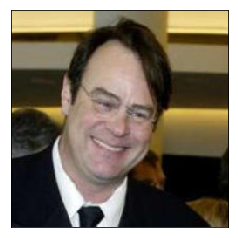

If you were a dog you would be a ...


RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'

In [95]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)
    
my_files = np.array(glob("./uploaded images/*"))

for file in my_files:
    run_app(file)
    